<a href="https://colab.research.google.com/github/helenatong/oc_p7_score_bancaire/blob/main/notebooks/Tong_Helena_2_b_notebook_modelisation_012025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prérequis**
- Télécharger [le zip]() dans Google Drive

---

## **Contexte et description du notebook**
- La société "Prêt à dépenser" propose des crédits à la consommation et souhaite créer un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit. C'est un outil d'aide à la décision pour aider la société à déterminer la solvabilité d'un client et de choisir si oui ou non elle accordera la demande de crédit.
- Ce notebook vise à entrainer différents modèles et d'enregistrer les différents runs via MLFlow.
---



# **I. Installation et mise en place de l'environnement de travail**

In [1]:
!pip install mlflow
!pip install pyngrok
!pip install imblearn
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.4 MB/s eta 0:00:00


In [2]:
# Librairies système et utilitaires
import os
import sys
import time
import datetime
from joblib import dump

# Librairies de manipulation de données
import numpy as np
import pandas as pd
import zipfile

# Librairies de visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Librairies Machine Learning - Scikit-learn
import sklearn
from sklearn import set_config
from sklearn.metrics import (
    confusion_matrix,
    make_scorer,
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import lightgbm
from lightgbm import LGBMClassifier

# Librairies pour le traitement du déséquilibre des classes
import imblearn
from imblearn.over_sampling import (
    SMOTE,
    RandomOverSampler
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Librairies de tracking et déploiement
import mlflow
from mlflow.models import infer_signature
from pyngrok import ngrok
import joblib

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Informations sur l'environnement virtuel
print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)
print('Mlflow        : ' + mlflow.__version__)
print('Imblearn      : ' + imblearn.__version__)
print('Sklearn       : ' + sklearn.__version__)
print('Lightgbm      : ' + lightgbm.__version__)
print('Joblib        : ' + joblib.__version__)
print('Shap          : ' + shap.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
NumPy         : 1.26.4
Pandas        : 2.2.2
Matplotlib    : 3.10.0
Seaborn       : 0.13.2
Mlflow        : 2.19.0
Imblearn      : 0.13.0
Sklearn       : 1.6.0
Lightgbm      : 4.5.0
Joblib        : 1.4.2
Shap          : 0.46.0
Run date      : 2025-01-17T22:03:53.190315


In [4]:
# Connexion au drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Récupérer le fichier
df = pd.read_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_7/data/aggregated_df_30_variables.pq')

df = df.drop(columns=['SK_ID_CURR']) #Retirer la colonne ID pour l'entrainement du modèle
print(df.shape)
df.head()

(307507, 31)


,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX,BURO_DAYS_CREDIT_MEAN,CC_AMT_BALANCE_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,DAYS_BIRTH,...,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,NAME_EDUCATION_TYPE_Higher education,BURO_STATUS_C_MEAN_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,APPROVED_DAYS_DECISION_MIN,REFUSED_HOUR_APPR_PROCESS_START_MIN,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY
0,1.0,0.139376,0.262949,0.083037,NaN,NaN,-874.00,NaN,0.75,-9461,...,0.000000,False,0.175426,0.0,-1134.0,0,-606.0,NaN,-2120,0
1,0.0,NaN,0.622246,0.311267,NaN,NaN,-1400.75,NaN,0.75,-16765,...,0.000000,True,NaN,0.0,-828.0,1,-2341.0,NaN,-291,0
2,0.0,0.729567,0.555912,NaN,NaN,NaN,-867.00,NaN,1.00,-19046,...,0.000000,False,NaN,0.0,-815.0,0,-815.0,NaN,-2531,0
3,0.0,NaN,0.650442,NaN,NaN,0.0,NaN,0.0,NaN,-19005,...,0.000000,False,NaN,0.0,-617.0,1,-617.0,15.0,-2437,0
4,0.0,NaN,0.322738,NaN,NaN,NaN,-1149.00,NaN,1.00,-19932,...,0.166667,False,NaN,0.0,-1106.0,0,-2357.0,NaN,-3458,1


# **II. Set up mlflow et contexte**

## **A. Création d'un score business**

L'accuracy est une métrique utile pour connaitre le taux de prédictions correctes (Vrai P, Vrai N, Faux P, Faux N).

Néanmoins, dans notre contexte, le fait de se tromper sur davantage de FP a des conséquences économiques beaucoup plus importante que de se tromper sur la prédiction de FN.

En effet, si le banquier accorde un prêt à une personne qui ne remboursera pas son prêt (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital), cela aura un coût beaucoup plus important que de ne pas accorder un prêt à une personne qui aurait remboursé le prix (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge).

Je vais supposer que le coût d'un FN est dix fois supérieur au coût d’un FP et je vais créer un score 'METIER', il sera utilisé comme fonction de coût à minimiser dans l'entrainement du modèle.

De plus, la prédiction d'un FN ou d'un FP est dépendant d'un seuil dont la valeur est 0,5 par défault. Or, en prenant une valeur différente, on peut minimiser le nombre de FN et donc limiter la perte économique. Et ce même si l'accuracy diminue.

En conclusion, pour l'entrainement des modèles, je vais chercher à minimiser le score business, en choisissant le seuil optimal (pour prédire la classe)et ainsi limiter le nombre de FN par rapport au FP, en me concentrant moins sur l'accuracy.



In [ ]:
# Définir la fonction de coût 'métier'

def find_best_threshold(y_true, y_pred_proba, cost_fn=10, cost_fp=1):
    """
    Trouve le meilleur seuil en minimisant le coût business
    """
    thresholds = np.arange(0, 1.01, 0.01)
    costs = []
    for threshold in thresholds:
      y_pred = (y_pred_proba >= threshold).astype(int)
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
      cost = cost_fn * fn + cost_fp * fp
      costs.append(cost)
    best_threshold = thresholds[np.argmin(costs)]
    return best_threshold, min(costs)


# Pour chaque modèle entrainé, le choix sera effectué en trouvant le threshold qui minimise la valeur cost
def custom_business_cost(y_true, y_pred_proba, cost_fn=10, cost_fp=1):
    """
    Fonction de score qui trouve le meilleur seuil et retourne le score business
    """
    # Trouver le meilleur seuil
    best_threshold, cost = find_best_threshold(y_true, y_pred_proba, cost_fn, cost_fp)
    return cost

# Créer le scorer avec needs_proba=True
custom_scorer = make_scorer(custom_business_cost, greater_is_better=False, needs_proba=True)
# Cela permet à scikit-learn de savoir qu'il doit appeler predict_proba sur le modèle pour obtenir les probabilités avant de passer ces valeurs à custom_business_cost.

## **B. Intégration avec MLFlow**

Les données issues de MLflow (metadata et artifacts) pour chaque run son enregistré dans un dossier local ml_runs.

Cliquez [ici](https://mlflow.org/docs/latest/tracking.html#concepts) pour avoir plus d'informations.

In [ ]:
# Set up de mlflow
ngrok.set_auth_token("2ocCVNEZRsBzJn6vmweGP7zTw66_27wNNxnaRFzY8buEbUW6K")

# Créer un dossier local s'il n'existe pas pour stocker les logs MLflow
mlflow_path = "/content/drive/MyDrive/openclassrooms/project_list/project_7/mlflow_experiments"
os.makedirs(mlflow_path, exist_ok=True)

# Configurer MLflow pour indiquer le lieu de stockage des différents experiments
local_server_uri = f"file:{mlflow_path}"

# Set up pour une avoir une interface utilisateur web mlflow
# Démarrer le serveur MLflow en arrière-plan
## get_ipython : autorise le notebook à run une commande shell
## system_raw: exécute la commande shellen argument
# get_ipython().system_raw("mlflow ui --port 5000 &")
mlflow.set_tracking_uri(local_server_uri)

# 5. Démarrer le serveur MLflow
get_ipython().system_raw(f"mlflow ui --backend-store-uri file:{mlflow_path} --port 5000 &")


# Créer un tunnel pour le port 5000 et visualiser les trackings
public_url = ngrok.connect(5000)
print("MLflow Tracking UI:", public_url)

# Créer un expériment
mlflow.set_experiment("MLflow Naive model runs" + now)

MLflow Tracking UI: NgrokTunnel: "https://0fde-34-86-82-175.ngrok-free.app" -> "http://localhost:5000"


2025/01/13 18:29:07 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Naive model runs2025-01-13T18:28:25.416221' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/openclassrooms/project_list/project_7/mlflow_experiments/105530984179477204', creation_time=1736792947771, experiment_id='105530984179477204', last_update_time=1736792947771, lifecycle_stage='active', name='MLflow Naive model runs2025-01-13T18:28:25.416221', tags={}>

# **III. Entrainement du modèle naïf**

Je vais commencer par entrainer un modèle naïf (LogisticRegression), sans équilibre de classe, sans grid search en optimisant le score d'accuracy.

Ce sera mon modèle de référence pour l'entrainement du modèle principal.

On va créer 2 modèles de référence:
- Un modèle sans équilibre de classe
- Un modèle avec équilibre de classe (SMOTE)

In [ ]:
# Charger les données
y = df['TARGET']
X = df.drop(columns = ['TARGET'])

## **A. Sans équilibre de classe**

In [ ]:
# Préparation des pipelines et modèle
## Construction de la pipeline de preprocessing
preprocessing_pipeline = sklearn.pipeline.Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

## Construction de la pipeline principale
main_pl = sklearn.pipeline.Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('model', LogisticRegression())
])

main_pl

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('model', LogisticRegression())])

In [ ]:
## RUN 1
with mlflow.start_run(run_name='Naive_model_no_modification'+now):
    # Entrainement du modèle
    ## Diviser les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    ## Paramètres du modèle
    param_grid = {
        "preprocessor__imputer__strategy": ["median"],
        "model__C": [10, 1, 0.10, 0.01], # Paramètres de régularisation, C petit évite le risque de surapprentissage
        "model__random_state": [42],
    }
    pl = GridSearchCV(main_pl, param_grid=param_grid , cv=3, scoring=custom_scorer, n_jobs=-1, verbose=1)
    pl.fit(X_train, y_train)
    best_model = pl.best_estimator_
    print("Best model:", best_model, end='\n\n')
    print(set_config(display="diagram"))
    best_params = pl.best_params_
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Évaluation du modèle
    ## ACCURACY
    train_accuracy_score = round(accuracy_score(y_train, y_pred_train), 2)
    test_accuracy_score = round(accuracy_score(y_test, y_pred_test), 2)
    print("train score accuracy:", train_accuracy_score)
    print("test score accuracy:", test_accuracy_score, end='\n\n')
    ## AUC
    y_pred_proba_train = pl.predict_proba(X_train)[:, 1]
    y_pred_proba_test = pl.predict_proba(X_test)[:, 1]
    train_auc_score = round(roc_auc_score(y_train, y_pred_proba_train), 2)
    test_auc_score = round(roc_auc_score(y_test, y_pred_proba_test), 2)
    print("AUC train score:", train_auc_score)
    print("AUC test score:", test_auc_score, end='\n\n')
    ## SCORE BUSINESS
    train_business_score = custom_business_cost(y_train, y_pred_train)
    test_business_score = custom_business_cost(y_test, y_pred_test)
    print("Business train score:", train_business_score)
    print("Business test score:", test_business_score)
    ### Pour comparer le train/test en s'affranchissant de la taille du jeu de données
    train_business_score_per_person = round(train_business_score/X_train.shape[0], 2)
    test_business_score_per_person = round(test_business_score/X_test.shape[0], 2)
    print("Business train score per person:", train_business_score_per_person)
    print("Business test score per person:", test_business_score_per_person)
    ## Récupérer le meilleur threshold pour le log dans le modèle
    best_threshold_train = find_best_threshold(y_train, y_pred_proba_train)[0]
    best_threshold_test = find_best_threshold(y_test, y_pred_proba_test)[0]
    print("Best threshold train:", best_threshold_train)
    print("Best threshold test:", best_threshold_test)
    ## Obtenir la matrice de confusion pour plus de détails
    train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train, y_pred_train).ravel()
    test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test, y_pred_test).ravel()
    print(f"Nombre de faux négatif train {train_fn} pour {X_train.shape[0]} individus, soit {round(100*train_fn/X_train.shape[0], 2)}%")
    print(f"Nombre de faux négatif test {test_fn} pour {X_test.shape[0]} individus, soit {round(100*test_fn/X_test.shape[0], 2)}%")

    # Log les hyperparametres
    mlflow.log_params(best_params)

    # Log les métrics
    mlflow.log_metric("train_accuracy_score", train_accuracy_score)
    mlflow.log_metric("test_accuracy_score", test_accuracy_score)
    mlflow.log_metric("train_auc_score", train_auc_score)
    mlflow.log_metric("test_auc_score", test_auc_score)
    mlflow.log_metric("train_business_score", train_business_score)
    mlflow.log_metric("test_business_score", test_business_score)
    mlflow.log_metric("train_business_score_per_person", train_business_score_per_person)
    mlflow.log_metric("test_business_score_per_person", test_business_score_per_person)
    mlflow.log_metric("train_best_threshold", best_threshold_train)
    mlflow.log_metric("test_best_threshold", best_threshold_test)
    mlflow.log_metrics({
        "train_faux_neg": train_fn,
        "train_faux_pos": train_fp,
        "train_vrai_neg": train_tn,
        "train_vrai_pos": train_tp
    })
    mlflow.log_metrics({
        "test_faux_neg": test_fn,
        "test_faux_pos": test_fp,
        "test_vrai_neg": test_tn,
        "test_vrai_pos": test_tp
    })

    # Set le tag
    mlflow.set_tag("Training Info", "Naive_model_no_modification")

    # Créer la signature du modèle
    signature = infer_signature(X_train, pl.predict(X_train))

    # Log le modèle
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="Naive_model_no_modification",
        signature=signature,
        input_example=X_train,
        registered_model_name="Naive_model_no_modification",
    )

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Best model: Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])),
                ('model', LogisticRegression(C=10, random_state=42))])

None
train score accuracy: 0.92
test score accuracy: 0.92

AUC train score: 0.74
AUC test score: 0.74

Business train score: 196462
Business test score: 49015
Business train score per person: 0.8
Business test score per person: 0.8
Best threshold train: 0.09
Best threshold test: 0.09
Nombre de faux négatif train 19622 pour 246005 individus, soit 7.98%
Nombre de faux négatif test 4896 pour 61502 individus, soit 7.96%


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Naive_model_no_modification' already exists. Creating a new version of this model...
Created version '7' of model 'Naive_model_no_modification'.


In [ ]:
# Sauvegarder le modèle
joblib.dump(best_model, '/content/drive/MyDrive/openclassrooms/project_list/project_7/saved_model/Naive_model_no_modification.joblib')

['/content/drive/MyDrive/openclassrooms/project_list/project_7/saved_model/Naive_model_no_modification.joblib']

## **B. Avec équilibre de classe (oversampling SMOTE)**

In [ ]:
# Construction de la pipeline principale
## imblearn.pipeline.Pipeline n'accepte pas d'objet PL dans la PL
main_pl = imblearn.pipeline.Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('over_sampling', SMOTE()), # over-sampling
    ('model', LogisticRegression())
])

main_pl

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('over_sampling', SMOTE()), ('model', LogisticRegression())])

In [ ]:
## RUN 2
with mlflow.start_run(run_name='Naive_model_SMOTE_class_balance'+now):
    # Entrainement du modèle
    ## Diviser les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    ## Paramètres du modèle
    param_grid = {
        "imputer__strategy": ['median'],
        # "over_sampling__sampling_strategy": [0.1, 0.2, 0.3, 0.4], #0.5 = oversampler jusqu'à ce que n(classe minoritaire) = 0.5*n(classe majoritaire)
        "over_sampling__sampling_strategy": ['minority', 'not minority', 'all'], #'minority': resample only the minority class
        "over_sampling__k_neighbors": [4, 5, 6], # Détermine le nombre de voisins pour l'oversampling, plus c'est grand, plus c'est diversifié
        "over_sampling__random_state": [42],
        "model__C": [0.10, 0.01], # Paramètres de régularisation, C petit évite le risque de surapprentissage
        "model__random_state": [42]
    }
    pl = GridSearchCV(main_pl, param_grid=param_grid , cv=3, scoring=custom_scorer, n_jobs=-1, verbose=1)
    pl.fit(X_train, y_train)
    best_model = pl.best_estimator_
    print("Best model:", best_model, end='\n\n')
    print(set_config(display="diagram"))
    best_params = pl.best_params_
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Évaluation du modèle
    ## ACCURACY
    train_accuracy_score = round(accuracy_score(y_train, y_pred_train), 2)
    test_accuracy_score = round(accuracy_score(y_test, y_pred_test), 2)
    print("train score accuracy:", train_accuracy_score)
    print("test score accuracy:", test_accuracy_score, end='\n\n')
    ## AUC
    y_pred_proba_train = pl.predict_proba(X_train)[:, 1]
    y_pred_proba_test = pl.predict_proba(X_test)[:, 1]
    train_auc_score = round(roc_auc_score(y_train, y_pred_proba_train), 2)
    test_auc_score = round(roc_auc_score(y_test, y_pred_proba_test), 2)
    print("AUC train score:", train_auc_score)
    print("AUC test score:", test_auc_score, end='\n\n')
    ## SCORE BUSINESS
    train_business_score = custom_business_cost(y_train, y_pred_train)
    test_business_score = custom_business_cost(y_test, y_pred_test)
    print("Business train score total:", train_business_score)
    print("Business test score total:", test_business_score)
    ### Pour comparer le train/test en s'affranchissant de la taille du jeu de données
    train_business_score_per_person = round(train_business_score/X_train.shape[0], 2)
    test_business_score_per_person = round(test_business_score/X_test.shape[0], 2)
    print("Business train score per person:", train_business_score_per_person)
    print("Business test score per person:", test_business_score_per_person)
    ## Récupérer le meilleur threshold pour le log dans le modèle
    best_threshold_train = find_best_threshold(y_train, y_pred_proba_train)[0]
    best_threshold_test = find_best_threshold(y_test, y_pred_proba_test)[0]
    print("Best threshold train:", best_threshold_train)
    print("Best threshold test:", best_threshold_test)
    ## Obtenir la matrice de confusion pour plus de détails
    train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train, y_pred_train).ravel()
    test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test, y_pred_test).ravel()
    print(f"Nombre de faux négatif train {train_fn} pour {X_train.shape[0]} individus, soit {round(100*train_fn/X_train.shape[0], 2)}%")
    print(f"Nombre de faux négatif test {test_fn} pour {X_test.shape[0]} individus, soit {round(100*train_fn/X_test.shape[0], 2)}%")

    # Log les hyperparametres
    mlflow.log_params(best_params)

    # Log les métrics
    mlflow.log_metric("train_accuracy_score", train_accuracy_score)
    mlflow.log_metric("test_accuracy_score", test_accuracy_score)
    mlflow.log_metric("train_auc_score", train_auc_score)
    mlflow.log_metric("test_auc_score", test_auc_score)
    mlflow.log_metric("train_business_score", train_business_score)
    mlflow.log_metric("test_business_score", test_business_score)
    mlflow.log_metric("train_business_score_per_person", train_business_score_per_person)
    mlflow.log_metric("test_business_score_per_person", test_business_score_per_person)
    mlflow.log_metric("train_best_threshold", best_threshold_train)
    mlflow.log_metric("test_best_threshold", best_threshold_test)
    mlflow.log_metrics({
        "train_faux_neg": train_fn,
        "train_faux_pos": train_fp,
        "train_vrai_neg": train_tn,
        "train_vrai_pos": train_tp
    })
    mlflow.log_metrics({
        "test_faux_neg": test_fn,
        "test_faux_pos": test_fp,
        "test_vrai_neg": test_tn,
        "test_vrai_pos": test_tp
    })

    # Set le tag
    mlflow.set_tag("Training Info", "Naive_model_SMOTE_class_balance")

    # Créer la signature du modèle
    signature = infer_signature(X_train, pl.predict(X_train))

    # Log le modèle
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="Naive_model_SMOTE_class_balance",
        signature=signature,
        input_example=X_train,
        registered_model_name="Naive_model_SMOTE_class_balance",
    )

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


Best model: Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('over_sampling',
                 SMOTE(k_neighbors=4, random_state=42, sampling_strategy=0.1)),
                ('model', LogisticRegression(C=0.1, random_state=42))])

None
train score accuracy: 0.92
test score accuracy: 0.92

AUC train score: 0.74
AUC test score: 0.74

Business train score total: 195456
Business test score total: 48992
Business train score per person: 0.79
Business test score per person: 0.8
Best threshold train: 0.1
Best threshold test: 0.1
Nombre de faux négatif train 19507 pour 246005 individus, soit 7.93%
Nombre de faux négatif test 4890 pour 61502 individus, soit 31.72%


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Naive_model_SMOTE_class_balance' already exists. Creating a new version of this model...
Created version '6' of model 'Naive_model_SMOTE_class_balance'.


In [ ]:
# Sauvegarder le modèle
joblib.dump(best_model, '/content/drive/MyDrive/openclassrooms/project_list/project_7/saved_model/Naive_model_SMOTE_class_balance.joblib')

['/content/drive/MyDrive/openclassrooms/project_list/project_7/saved_model/Naive_model_SMOTE_class_balance.joblib']

**Conclusion des entrainements avec et sans équilibre de classe**

Le modèle avec équilibre de classe est plus performant si on regarde le score business (137 420 contre 196 498), malgré un score d'accuracy plus faible (0.68 contre 0.92).


# **IV. Entrainement du modèle LightGBM**

In [ ]:
# Un modèle de boosting par gradient

# Construction de la pipeline principale
## imblearn.pipeline.Pipeline n'accepte pas d'objet PL dans la PL

main_pl = imblearn.pipeline.Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    # ('class_imbalance', SMOTE()), #Gestion du déséquilibre de classe via l'argument is_balanced dans l'entrainement du modèle
    ('model', LGBMClassifier())
])

main_pl

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('model', LGBMClassifier())])

In [ ]:
## RUN 3 34m
with mlflow.start_run(run_name='lightgbm_model'+now):
    # Entrainement du modèle
    ## Diviser les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    ## Paramètres du modèle
    param_grid = {
        "imputer__strategy": ['median'],
        "model__n_estimators": [1000], #Nombre d'arbres d'entrainement
        "model__learning_rate": [0.01, 0.1], # Pas d'apprentissage, trop petit = entrainement lent, trop grand = risque de manquer un optimum
        "model__max_depth": [7, 8, 9], # Profondeur maximale de chaque arbre
        "model__num_leaves": [20, 24, 28, 32], # num_leaves <= 2^max_depth
        "model__is_unbalance": ['True', 'False'], # Gestion des classes déséquilibrées
        "model__random_state": [42]
    }
    pl = GridSearchCV(main_pl, param_grid=param_grid , cv=3, scoring=custom_scorer, n_jobs=-1, verbose=1)
    pl.fit(X_train, y_train)
    best_model = pl.best_estimator_
    print("Best model:", best_model, end='\n\n')
    print(set_config(display="diagram"))
    best_params = pl.best_params_
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Évaluation du modèle
    ## ACCURACY
    train_accuracy_score = round(accuracy_score(y_train, y_pred_train), 2)
    test_accuracy_score = round(accuracy_score(y_test, y_pred_test), 2)
    print("train score accuracy:", train_accuracy_score)
    print("test score accuracy:", test_accuracy_score, end='\n\n')
    ## AUC
    y_pred_proba_train = pl.predict_proba(X_train)[:, 1]
    y_pred_proba_test = pl.predict_proba(X_test)[:, 1]
    train_auc_score = round(roc_auc_score(y_train, y_pred_proba_train), 2)
    test_auc_score = round(roc_auc_score(y_test, y_pred_proba_test), 2)
    print("AUC train score:", train_auc_score)
    print("AUC test score:", test_auc_score, end='\n\n')
    ## SCORE BUSINESS
    train_business_score = custom_business_cost(y_train, y_pred_train)
    test_business_score = custom_business_cost(y_test, y_pred_test)
    print("Business train score:", train_business_score)
    print("Business test score:", test_business_score)
    ### Pour comparer le train/test en s'affranchissant de la taille du jeu de données
    train_business_score_per_person = round(train_business_score/X_train.shape[0], 2)
    test_business_score_per_person = round(test_business_score/X_test.shape[0], 2)
    print("Business train score per person:", train_business_score_per_person)
    print("Business test score per person:", test_business_score_per_person)
    ## Récupérer le meilleur threshold pour le log dans le modèle
    best_threshold_train = find_best_threshold(y_train, y_pred_proba_train)[0]
    best_threshold_test = find_best_threshold(y_test, y_pred_proba_test)[0]
    print("Best threshold train:", best_threshold_train)
    print("Best threshold test:", best_threshold_test)
    ## Obtenir la matrice de confusion pour plus de détails
    train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train, y_pred_train).ravel()
    test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test, y_pred_test).ravel()
    print(f"Nombre de faux négatif train {train_fn} pour {X_train.shape[0]} individus, soit {round(100*train_fn/X_train.shape[0], 2)}%")
    print(f"Nombre de faux négatif test {test_fn} pour {X_test.shape[0]} individus, soit {round(100*train_fn/X_test.shape[0], 2)}%")

    # Log les hyperparametres
    mlflow.log_params(best_params)

    # Log les métrics
    mlflow.log_metric("train_accuracy_score", train_accuracy_score)
    mlflow.log_metric("test_accuracy_score", test_accuracy_score)
    mlflow.log_metric("train_auc_score", train_auc_score)
    mlflow.log_metric("test_auc_score", test_auc_score)
    mlflow.log_metric("train_business_score", train_business_score)
    mlflow.log_metric("test_business_score", test_business_score)
    mlflow.log_metric("train_business_score_per_person", train_business_score_per_person)
    mlflow.log_metric("test_business_score_per_person", test_business_score_per_person)
    mlflow.log_metric("train_best_threshold", best_threshold_train)
    mlflow.log_metric("test_best_threshold", best_threshold_test)
    mlflow.log_metrics({
        "train_faux_neg": train_fn,
        "train_faux_pos": train_fp,
        "train_vrai_neg": train_tn,
        "train_vrai_pos": train_tp
    })
    mlflow.log_metrics({
        "test_faux_neg": test_fn,
        "test_faux_pos": test_fp,
        "test_vrai_neg": test_tn,
        "test_vrai_pos": test_tp
    })

    # Set le tag
    mlflow.set_tag("Training Info", "lightgbm_model")

    # Créer la signature du modèle
    signature = infer_signature(X_train, pl.predict(X_train))

    # Log le modèle
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="lightgbm_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="lightgbm_model",
    )

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5125
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
Best model: Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('model',
                 LGBMClassifier(is_unbalance='True', learning_rate=0.01,
                                max_depth=7, n_estimators=1000, num_leaves=20,
                                random_state=42))])

None


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The L

train score accuracy: 0.7
test score accuracy: 0.69



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The L

AUC train score: 0.78
AUC test score: 0.75

Business train score: 126055
Business test score: 32831
Business train score per person: 0.51
Business test score per person: 0.53
Best threshold train: 0.54
Best threshold test: 0.51
Nombre de faux négatif train 5679 pour 246005 individus, soit 2.31%
Nombre de faux négatif test 1535 pour 61502 individus, soit 9.23%


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

In [ ]:
# Sauvegarder le modèle
lightgbm_model_file_path = "/content/drive/MyDrive/openclassrooms/project_list/project_7/saved_model/lightgbm_model.joblib"
joblib.dump(best_model, lightgbm_model_file_path)

['/content/drive/MyDrive/openclassrooms/project_list/project_7/saved_model/lightgbm_model.joblib']

**Conclusion des entrainements**

Le modèle avec équilibre de classe est moins performant si on regarde le score business (137 420 contre 123 084) et le score d'accuracy (0.7 contre 0.68).

Le modèle LightGBM nécessite plus de temps de calcul (30 minnutes), mais pour des raisons de performance, je vais choisir le modèle LightGBM.


# **V. Explication du modèle**

In [8]:
lightgbm_model_file_path = "/content/drive/MyDrive/openclassrooms/project_list/project_7/saved_model/lightgbm_model.joblib"
best_pl = joblib.load(lightgbm_model_file_path)

df = pd.read_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_7/data/aggregated_df_30_variables.pq')
df = df.drop(columns=['SK_ID_CURR']) #Retirer la colonne ID pour l'entrainement du modèle

In [9]:
# Afficher la structure de la pipeline
print("Type de best_pl:", type(best_pl))
print("Composants disponibles:", best_pl.named_steps)

Type de best_pl: <class 'imblearn.pipeline.Pipeline'>
Composants disponibles: {'imputer': SimpleImputer(strategy='median'), 'scaler': MinMaxScaler(), 'model': LGBMClassifier(is_unbalance='True', learning_rate=0.01, max_depth=7,
               n_estimators=1000, num_leaves=20, random_state=42)}


In [13]:
nb_shap_values = 20000
# Charger les données
y = df['TARGET']
X = df.drop(columns = ['TARGET'])

# Equilibre de classe
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)
print('Dimension après équilibre de classe', X_balanced.shape)

# Prendre une partie des données
X_sample, _, y_sample, _ = train_test_split(X_balanced, y_balanced, train_size=nb_shap_values, stratify=y_balanced, random_state=42)

X_test_preprocessed = best_pl['imputer'].transform(X_sample)
X_test_preprocessed = best_pl['scaler'].transform(X_test_preprocessed)

print("Vérifier les proportions: \n", y_sample.value_counts(normalize=True))  # vérifier les proportions

Dimension après équilibre de classe (49650, 30)
Vérifier les proportions TARGET
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


In [14]:
# Entrainement
shap.initjs()
start_time = datetime.datetime.now()
explainer = shap.Explainer(best_pl['model'], X_test_preprocessed)
shap_values = explainer(X_test_preprocessed, check_additivity=False) #fit
print("Temps de calcul: ", datetime.datetime.now()-start_time)

100%|===================| 19970/20000 [12:20<00:01]       

Temps de calcul:  0:12:22.011296


Top 10 des features qui expliquent le plus le modèle


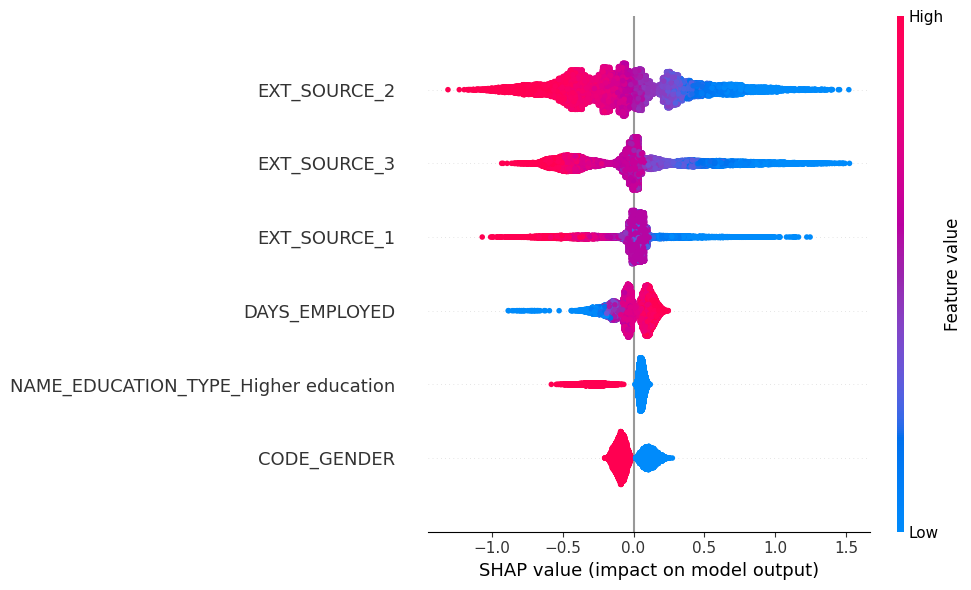

Temps de calcul:  0:00:03.643961


In [34]:
# Top 10 des features qui expliquent le plus le modèle
print("Top 10 des features qui expliquent le plus le modèle")
start_time = datetime.datetime.now()
shap.summary_plot(shap_values, feature_names=X.columns, max_display=6, plot_size=(10,6))
print("Temps de calcul: ", datetime.datetime.now()-start_time)

Les variables ayant le plus d’impact sur le modèle sont EXT_SOURCE_1, EXT_SOURCE_2, et EXT_SOURCE_3.

D'après la [documentation](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook), ces variables sont des "scores normalisés provenant de sources de données externes". Le résultat montre que ce sont des indicateurs synthétiques pertinents pour déterminer si un prêt a une forte probabilité d'être remboursé ou non et donc si le crédit est accordé ou non. Un valeur haute impacte négativement la décision de prêt.

DAYS_EMPLOYED, qui reflète la stabilité professionnelle (durée d’emploi), est également un facteur important : ne pas avoir un emploi stable augmente l’hésitation des banques à accorder un prêt.

Être un homme influence positivement l’accord du crédit.

Avec étonnement, être issue d’une formation décrite comme 'Higher education', avoir une moyenne faible de contrats refusée impactent négativement l'accord d'un prêt.


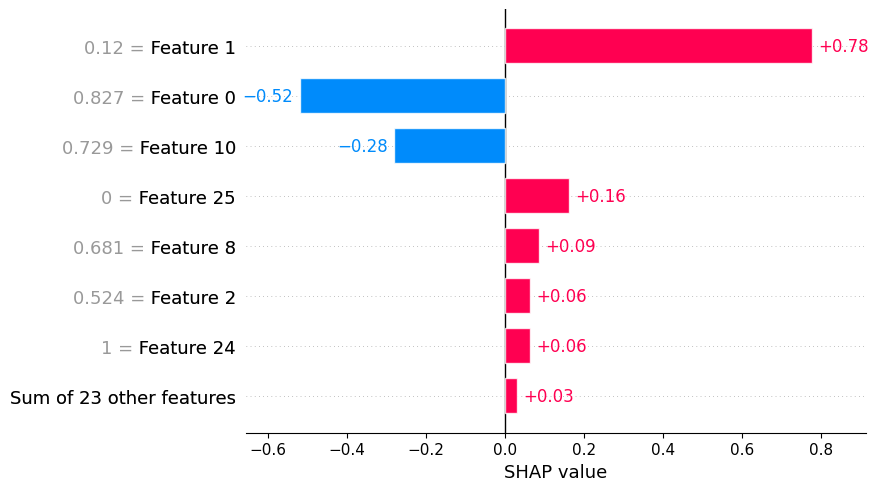

1:  EXT_SOURCE_2
0:  EXT_SOURCE_3
10:  DAYS_EMPLOYED
25:  CODE_GENDER
8:  DAYS_BIRTH
2:  EXT_SOURCE_1
24:  DAYS_LAST_PHONE_CHANGE
21:  NAME_EDUCATION_TYPE_Higher education
3:  CC_CNT_DRAWINGS_ATM_CURRENT_MEAN


In [36]:
# Individu
shap.plots.bar(shap_values[0], max_display=8)
print("1: ", feature_names[1])
print("0: ", feature_names[0])
print("10: ", feature_names[10])
print("25: ", feature_names[25])
print("8: ", feature_names[8])
print("2: ", feature_names[2])
print("24: ", feature_names[24])

In [41]:
# Valeurs pour la demande de crédit
df.loc[0, ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'CODE_GENDER', 'DAYS_BIRTH', 'EXT_SOURCE_1','DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education']]

,0
EXT_SOURCE_2,0.262949
EXT_SOURCE_3,0.139376
DAYS_EMPLOYED,-637.0
CODE_GENDER,0
DAYS_BIRTH,-9461
EXT_SOURCE_1,0.083037
DAYS_LAST_PHONE_CHANGE,-1134.0
NAME_EDUCATION_TYPE_Higher education,False


In [53]:
# Comparaison avec la moyenne pour les variables quantitatives
quantitative_columns = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE']
average_values = df.loc[:, quantitative_columns].mean()
average_df = pd.DataFrame(average_values, columns=['average_value'])
average_df

,average_value
EXT_SOURCE_2,0.514392
EXT_SOURCE_3,0.510856
DAYS_EMPLOYED,-2384.142254
DAYS_BIRTH,-16037.027271
EXT_SOURCE_1,0.502129
DAYS_LAST_PHONE_CHANGE,-962.860546


Explications SHAP individuel:

EXT_SOURCE 2 (+0.78) et 3 (-0.52) ont le plus d’impact sur la décision d'accord de crédit.
La personne a un travail depuis 2,5 ans contre 6,5 ans en moyenne, ce qui est un malus.
C’est un homme de 26 ans donc à priori sa jeunesse a facilité sa demande de prêt.

